In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

precision = 2
np.set_printoptions(precision=precision, suppress=True)
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
VERBOSE = 1

In [2]:
def svd(matrix, threshold=-np.inf):
    U, S, Vt = np.linalg.svd(matrix)
    I = np.where(S > threshold)[0]
    return U[:,I], np.diag(S[I]), Vt[I,:]

L = np.array([
    [ 1.25,  1.05,  1.12,  1.57,   np.nan],
    [ 0.83,  1.13,  1.02,  0.35,  0.18],
    [ 0.  ,  0.35,  0.21, -0.56,  1.02],
    [-0.12,   np.nan,   np.nan,   np.nan,  0.98]
])
L = L[:-1, :-1]
U_high, S_high, Vt_high = svd(L, threshold=-np.inf)
A_high = np.dot(U_high, np.dot(S_high, Vt_high))
U_low, S_low, Vt_low = svd(L, threshold=0.008)
A_low = np.dot(U_low, np.dot(S_low, Vt_low))
print(f"L:\n{L}")
print("U:")
print(U_low)
print("Singular Values Sigma:")
print(S_low)
print("V^*:")
print(Vt_low)
print("Approximation by full Singular Value Decomposition, Approximation by low-rank SVD")
print(A_high, np.linalg.norm(L - A_high))
print(A_low, np.linalg.norm(L - A_low))

L:
[[ 1.25  1.05  1.12  1.57]
 [ 0.83  1.13  1.02  0.35]
 [ 0.    0.35  0.21 -0.56]]
U:
[[ 0.83  0.4 ]
 [ 0.56 -0.6 ]
 [-0.   -0.69]]
Singular Values Sigma:
[[3. 0.]
 [0. 1.]]
V^*:
[[ 0.5   0.5   0.5   0.5 ]
 [ 0.   -0.5  -0.31  0.81]]
Approximation by full Singular Value Decomposition, Approximation by low-rank SVD
[[ 1.25  1.05  1.12  1.57]
 [ 0.83  1.13  1.02  0.35]
 [-0.    0.35  0.21 -0.56]] 2.3713755970532924e-15
[[ 1.25  1.05  1.12  1.57]
 [ 0.83  1.13  1.02  0.35]
 [-0.    0.35  0.21 -0.56]] 0.007812893588175152


In [3]:
L = np.array([
    [1.25, 0.83, 0, -0.12],
    [1.05, 1.13, 0.35, np.nan],
    [1.12, 1.02, 0.21, np.nan],
    [1.57, 0.35, -0.56, np.nan],
    [np.nan, 0.18, 1.02, 0.98]
])
L = L[:-1,:-1]
print(f"L:\n{L}")

L:
[[ 1.25  0.83  0.  ]
 [ 1.05  1.13  0.35]
 [ 1.12  1.02  0.21]
 [ 1.57  0.35 -0.56]]


In [4]:
U, S, Vt = svd(L)
A = np.dot(U, np.dot(S, Vt))
print(A, np.linalg.norm(L-A), "L_2 error of SVD approximation. U, Sigma, V^*")
print(U)
print(S)
print(Vt)

[[ 1.25  0.83  0.  ]
 [ 1.05  1.13  0.35]
 [ 1.12  1.02  0.21]
 [ 1.57  0.35 -0.56]] 8.782087925385518e-16 L_2 error of SVD approximation. U, Sigma, V^*
[[-0.5   0.    0.31]
 [-0.5  -0.5   0.5 ]
 [-0.5  -0.31 -0.81]
 [-0.5   0.81 -0.  ]]
[[3.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.   0.01]]
[[-0.83 -0.56  0.  ]
 [ 0.4  -0.6  -0.69]
 [ 0.39 -0.58  0.72]]


In [5]:
r = 2
target = L[r,:].copy()
print(target)

[1.12 1.02 0.21]


In [6]:
def influence_user(matrix, instances=0, r=2, c=1, party_line=True):
    M = matrix.copy()
    if instances > 0:
        tell = np.zeros((M.shape[0], instances))
        tell[r,:] = 1.0
        M = np.hstack((M, tell))
        echo = M[r,:].copy()
        chamber = np.tile(echo[np.newaxis,:], (instances,1))
        M = np.vstack((M, chamber))
    target = M[r,:].copy()
    if not party_line:
        M = M + np.random.normal(0, 0.1, M.shape)
    M[r,c] = np.nan
    minor = np.delete(M, r, axis=0)
    return M, minor, target

M, M_minor, target = influence_user(L, instances=0)
print(f"\ntarget: {target}\nM:\n{M}\nM_m:\n{M_minor}\n")


target: [1.12 1.02 0.21]
M:
[[ 1.25  0.83  0.  ]
 [ 1.05  1.13  0.35]
 [ 1.12   nan  0.21]
 [ 1.57  0.35 -0.56]]
M_m:
[[ 1.25  0.83  0.  ]
 [ 1.05  1.13  0.35]
 [ 1.57  0.35 -0.56]]



In [7]:
def fill_user(L, r=2, instances=0, threshold=-np.inf, verbose=VERBOSE, party_line=True):
    L,L_minor,target = influence_user(L, instances=instances, party_line=party_line)
    unit = target / np.linalg.norm(target)
    prior = L[r,:]
    U, S, Vt = svd(L_minor, threshold=threshold)
    non_nan = ~np.isnan(prior)
    x = prior[non_nan]
    Vt_n = Vt
    for c in range(len(non_nan)):
        if not non_nan[c]:
            Vt_n = np.delete(Vt_n, c, axis=1)
    c = np.dot(x, Vt_n.T)
    post = np.dot(c, Vt)
    est = np.dot(c, np.dot(S, Vt))
    n = np.linalg.norm(est)
    est_norm = est / n
    e = np.dot(est_norm, unit) # np.linalg.norm(est_norm-unit)
    if verbose > 0:
        if verbose > 1:
            print(f"Non-normalized Target, Target: {target}, {unit}")
            print(f"L:\n{L}")
            print(f"Minor:\n{L_minor}")
            print(f"prior: {prior}")
            print(f"U:\n{U}")
        print(f"Singular Values:\n{S}")
        if verbose > 1:
            print(f"V^*:\n{Vt}")
            print(f"Target, Estimate:\n{unit}\n{est_norm}")
        print(f"L_2 error: {e}\n")
    return e, np.diagonal(S)

fill_user(L, instances=0, verbose=2)

Non-normalized Target, Target: [1.12 1.02 0.21], [0.73 0.67 0.14]
L:
[[ 1.25  0.83  0.  ]
 [ 1.05  1.13  0.35]
 [ 1.12   nan  0.21]
 [ 1.57  0.35 -0.56]]
Minor:
[[ 1.25  0.83  0.  ]
 [ 1.05  1.13  0.35]
 [ 1.57  0.35 -0.56]]
prior: [1.12  nan 0.21]
U:
[[-0.57 -0.12 -0.81]
 [-0.56 -0.66  0.5 ]
 [-0.6   0.74  0.31]]
Singular Values:
[[2.61 0.   0.  ]
 [0.   0.93 0.  ]
 [0.   0.   0.  ]]
V^*:
[[-0.86 -0.51  0.05]
 [ 0.33 -0.64 -0.69]
 [ 0.39 -0.58  0.72]]
Target, Estimate:
[0.73 0.67 0.14]
[ 0.89  0.45 -0.11]
L_2 error: 0.9336735687117121



(0.9336735687117121, array([2.61, 0.93, 0.  ]))

Non-normalized Target, Target: [1.12 1.02 0.21 1.  ], [0.61 0.56 0.11 0.55]
L:
[[ 1.25  0.83  0.    0.  ]
 [ 1.05  1.13  0.35  0.  ]
 [ 1.12   nan  0.21  1.  ]
 [ 1.57  0.35 -0.56  0.  ]
 [ 1.12  1.02  0.21  1.  ]]
Minor:
[[ 1.25  0.83  0.    0.  ]
 [ 1.05  1.13  0.35  0.  ]
 [ 1.57  0.35 -0.56  0.  ]
 [ 1.12  1.02  0.21  1.  ]]
prior: [1.12  nan 0.21 1.  ]
U:
[[-0.48  0.14  0.3   0.81]
 [-0.49 -0.24  0.68 -0.5 ]
 [-0.48  0.76 -0.31 -0.31]
 [-0.54 -0.59 -0.6   0.  ]]
Singular Values:
[[3.04 0.   0.   0.  ]
 [0.   1.09 0.   0.  ]
 [0.   0.   0.73 0.  ]
 [0.   0.   0.   0.  ]]
V^*:
[[-0.82 -0.55 -0.   -0.18]
 [ 0.42 -0.45 -0.58 -0.54]
 [-0.09  0.4   0.39 -0.82]
 [ 0.39 -0.58  0.72  0.01]]
Target, Estimate:
[0.61 0.56 0.11 0.55]
[ 0.79  0.49 -0.03  0.36]
L_2 error: 0.953192764919844

0 / 269
10 / 269
20 / 269
30 / 269
40 / 269
50 / 269
60 / 269
70 / 269
80 / 269
90 / 269
100 / 269
110 / 269
120 / 269
130 / 269
140 / 269
150 / 269
160 / 269
170 / 269
180 / 269
190 / 269
200 / 269
210 / 269

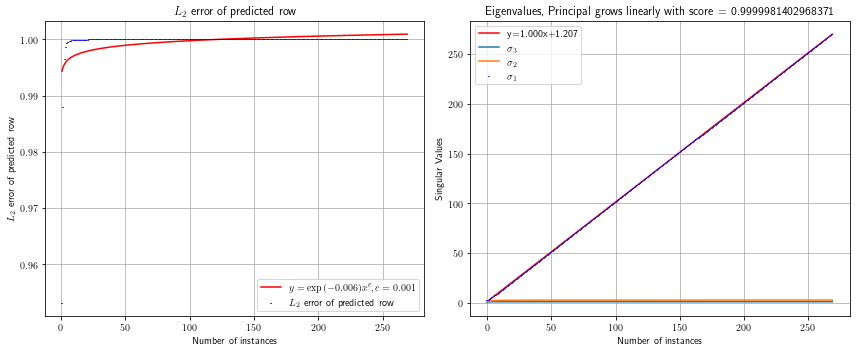

In [8]:
fill_user(L, instances=1, verbose=2)

e = []
num_users = 538
max_instances = int(num_users / 2)
INSTANCES = np.array(range(0,max_instances+1))
Lam = np.zeros((len(INSTANCES),3))

for instances in INSTANCES:
    if (instances % 10 == 0) or (instances==max_instances):
        print(f"{instances} / {max_instances:3}")
    ei, Si = fill_user(L, instances=instances, verbose=0, party_line=True)
    e.append(ei)
    Lam[instances,0] = Si[0]
    Lam[instances,1] = Si[1]
    Lam[instances,2] = Si[2]

l = LinearRegression().fit(np.log(INSTANCES[1:].reshape(-1,1)), np.log(e[1:]))
p = LinearRegression().fit(INSTANCES.reshape(-1,1), Lam[:,0])
ps = p.score(INSTANCES.reshape(-1,1), Lam[:,0])
    
fig,ax = plt.subplots(1,2, figsize=(12,5))
plt.title("Plots")

ax[0].plot(INSTANCES[1:], np.exp(np.log(INSTANCES[1:])*l.coef_[0] + l.intercept_), label=f"$\displaystyle y=\exp({l.intercept_:.3f})x^c, c={l.coef_[0]:.3f}$", linestyle="-", color="red")
ax[0].scatter(INSTANCES[1:], e[1:], label=r"$L_2$ error of predicted row", marker="|", s=1, color="blue", zorder=3)
ax[0].set_title(r"$L_2$ error of predicted row")
ax[0].set_xlabel("Number of instances")
ax[0].set_ylabel(r"$L_2$ error of predicted row")
ax[0].grid(True, which="both")
ax[0].legend()

ax[1].plot(INSTANCES, INSTANCES*p.coef_[0] + p.intercept_, label=f"y={p.coef_[0]:.3f}x+{p.intercept_:.3f}", linestyle="-", color="red")
ax[1].plot(INSTANCES, Lam[:,2], label=r"$\sigma_3$")
ax[1].plot(INSTANCES, Lam[:,1], label=r"$\sigma_2$")
ax[1].scatter(INSTANCES, Lam[:,0], label=r'$\sigma_1$', marker="|", s=1, color="blue", zorder=3)
ax[1].set_title(f"Eigenvalues, Principal grows linearly with score = {ps}")
ax[1].set_xlabel("Number of instances")
ax[1].set_ylabel("Singular Values")
ax[1].grid(True, which="both")
ax[1].legend()

plt.tight_layout()
plt.show()

In [9]:
instances = int(538/1)
fill_user(L, instances=instances, verbose=1, threshold=1e-11, party_line=True)
# fill_user(L, instances=instances, verbose=1, threshold=1e-11, party_line=False)

Singular Values:
[[539.17   0.     0.     0.     0.     0.  ]
 [  0.     2.6    0.     0.     0.     0.  ]
 [  0.     0.     0.93   0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.  ]]
L_2 error: 0.999999993281641



(0.999999993281641, array([539.17,   2.6 ,   0.93,   0.  ,   0.  ,   0.  ]))

In [10]:
df = pd.read_csv("./vitalstats_ch8_tbl4.csv")
print(df)
df["Score"] = pd.to_numeric(df["Score"], errors="coerce")
df = df.dropna(subset=["Score"])
latest = df[(df["Year"] == 2016)]
print(latest.to_string(index=False))

     Year Chamber          Party Score
0    1954   House  All Democrats    80
1    1955   House  All Democrats    84
2    1956   House  All Democrats    80
3    1957   House  All Democrats    79
4    1958   House  All Democrats    77
..    ...     ...            ...   ...
373  2012  Senate    Republicans    83
374  2013  Senate    Republicans    89
375  2014  Senate    Republicans    90
376  2015  Senate    Republicans    91
377  2016  Senate    Republicans    86

[378 rows x 4 columns]
 Year Chamber         Party  Score
 2016   House All Democrats   96.0
 2016   House   Republicans   96.0
 2016  Senate All Democrats   92.0
 2016  Senate   Republicans   86.0


In [11]:
print(df[(df["Year"] == 2014)].to_string(index=False))
# https://www.brookings.edu/articles/vital-statistics-on-congress/

 Year Chamber         Party  Score
 2014   House All Democrats   94.0
 2014   House   Republicans   95.0
 2014  Senate All Democrats   99.0
 2014  Senate   Republicans   90.0
